In [1]:
# Dependencies

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

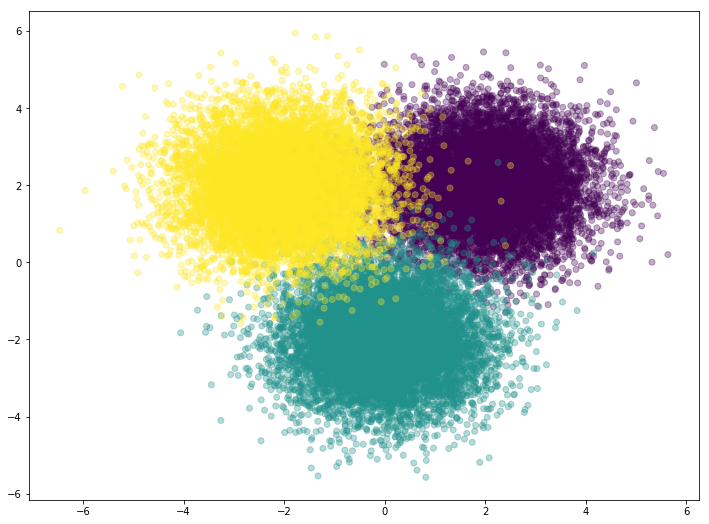

In [2]:
# Simulate Data

D = 2
K = 3
N = int(K*1e4)

X0 = np.random.randn((N//K),D) + np.array([2,2])
X1 = np.random.randn((N//K),D) + np.array([0,-2])
X2 = np.random.randn((N//K),D) + np.array([-2,2])
X = np.vstack((X0,X1,X2))

y = np.array([0]*(N//K) + [1]*(N//K) + [2]*(N//K))

plt.figure(figsize = (12,9))
plt.scatter(X[:,0],X[:,1],c = y,alpha = 0.3333)

In [3]:
# Data prep

Y = np.zeros((N,K))

for i in range(N):
    Y[i,y[i]] = 1

In [4]:
# Functions

def ReLU(H):
    return H*(H > 0)

def softmax(H):
    eH = np.exp(H)
    return eH / eH.sum(axis = 1, keepdims = True)

def feed_forward(X, W1, gamma1, beta1, W2, gamma2, beta2, mu, sigma2, epsilon): 
    H1 = np.matmul(X,W1)
    H1_bar = gamma1*((H1 - mu) / np.sqrt(sigma2 + epsilon)) + beta1
    Z1 = ReLU(H1_bar)
    H2 = np.matmul(Z1,W2)
    H2_bar = gamma2*((H2 - mu) / np.sqrt(sigma2 + epsilon)) + beta2
    P = softmax(H2_bar)
    return H1, H1_bar, Z1, H2, H2_bar, P

def cross_entropy(Y, P):
    return -np.sum(Y*np.log(P))

def accuracy(Y, P):
    return np.mean(Y.argmax(axis = 1) == P.argmax(axis = 1))

In [11]:
# Build the Model

M = 4

W1 = np.random.randn(D,M) / np.sqrt(D)
gamma1 = np.random.randn(1,M)
beta1 = np.random.randn(1,M)
W2 = np.random.randn(M,K) / np.sqrt(M)
gamma2 = np.random.randn(1,K)
beta2 = np.random.randn(1,K)

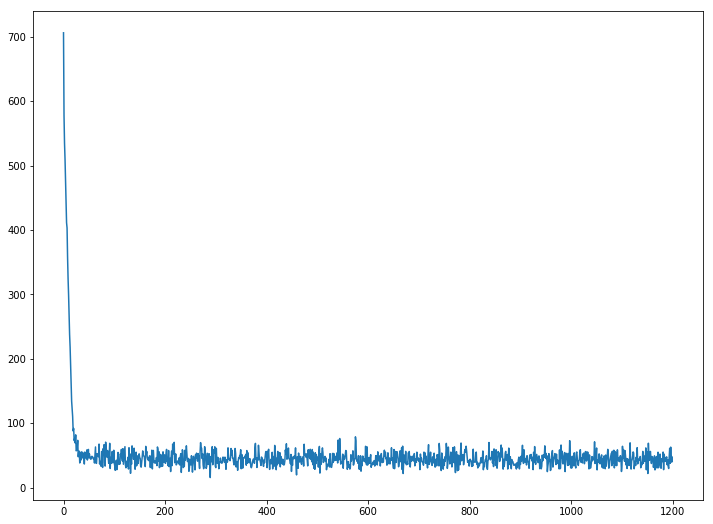

In [12]:
# Train the Model using Batch Normalization

J = []

eta = 1e-3
alpha = 0.99
mu = 0
sigma2 = 0
epsilon = 1e-10

batch = 500
epochs = 20

for t in range(20):
    idx = np.random.permutation(N)
    X = X[idx,:]
    Y = Y[idx,:]
    
    for i in range(N//batch):
        X_B = X[(i*batch):((i+1)*batch),:]
        Y_B = Y[(i*batch):((i+1)*batch),:]
        
        mu_B = (1/batch)*X_B.sum()
        sigma2_B = (1/(batch-1))*((X_B - mu_B)*(X_B - mu_B)).sum()
        
        mu = alpha*mu + (1 - alpha)*mu_B
        sigma2 = alpha*sigma2 + (1 - alpha)*sigma2_B
        
        H1_B, H1_bar_B, Z1_B, H2_B, H2_bar_B, P_B = feed_forward(X_B, W1, gamma1, beta1, W2, gamma2, beta2, mu_B, sigma2_B, epsilon)
        J.append(cross_entropy(Y_B, P_B))
        
        dH2_bar = P_B - Y_B
        dgamma2 = (dH2_bar*(H2_B - mu_B)/np.sqrt(sigma2_B + epsilon)).sum(axis = 0, keepdims = True)
        dbeta2 = dH2_bar.sum(axis = 0, keepdims = True)
        gamma2 -= eta*dgamma2
        beta2 -= eta*dbeta2
        dH2 = dH2_bar*gamma2 / np.sqrt(sigma2_B + epsilon)
        dW2 = np.matmul(Z1_B.T, dH2)
        W2 -= eta*dW2
        
        dZ1 = np.matmul(dH2, W2.T)
        dH1_bar = dZ1*(H1_bar_B > 0)
        dgamma1 = (dH1_bar*(H1_B - mu_B)/np.sqrt(sigma2_B + epsilon)).sum(axis = 0, keepdims = True)
        dbeta1 = dH1_bar.sum(axis = 0, keepdims = True)
        gamma1 -= eta*dgamma1
        beta1 -= eta*dbeta1
        dH1 = dH1_bar*gamma1 / np.sqrt(sigma2_B + epsilon)
        dW1 = np.matmul(X_B.T, dH1)
        W1 -= eta*dW1
        
plt.figure(figsize = (12,9))
plt.plot(J)

In [13]:
# Report Accuracy

P = feed_forward(X, W1, gamma1, beta1, W2, gamma2, beta2, mu, sigma2, epsilon)[-1]

print("Accuracy: {}".format(accuracy(Y,P)))

Accuracy: 0.9699666666666666
